In [39]:
import torch
from src.spaces.hyperbolic import HyperbolicSpace
from src.spectral_kernel import RandomSpectralKernel
from src.prior_approximation import RandomFourierApproximation
from src.spectral_measure import MaternSpectralMeasure, SqExpSpectralMeasure
import matplotlib.pyplot as plt
import gpytorch
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

dtype = torch.float64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [40]:
order = 10**3
space = HyperbolicSpace(n=2, order=order)

In [41]:
lengthscale, nu = 0.3, 5.0 + space.dim
measure = SqExpSpectralMeasure(space.dim, lengthscale)
#self.measure = MaternSpectralMeasure(self.space.dim, self.lengthscale, self.nu)

In [42]:
kernel = RandomSpectralKernel(measure, space)
sampler = RandomFourierApproximation(kernel)

In [43]:
def disk_to_hyperboloid(x):
    x_sq_norm = torch.sum(x * x, dim=1)
    t = ((x_sq_norm + 1)/(1-x_sq_norm))
    y = x * (1 + t)[:, None]
    return torch.cat((t.view(-1,1), y), dim=1)

def hyperboloid_to_disk(y):
    x = y[:, 1:]/((1+y[:,0])[:, None])
    return x

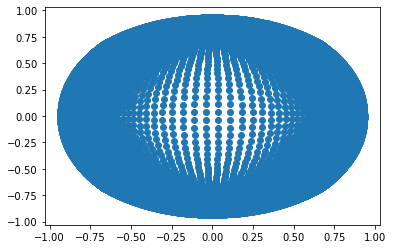

In [44]:
lspace = torch.linspace(-15, 15, steps=200, device=device, dtype=dtype)
#lspace = torch.sign(lspace) * torch.square(torch.abs(lspace))

y = torch.cartesian_prod(lspace, lspace)
y_sq_norm = torch.sum(y * y, dim=1)
t = torch.sqrt(1+y_sq_norm.view(-1,1))
y = torch.cat((t, y), dim=1)
x = hyperboloid_to_disk(y)
assert torch.allclose(disk_to_hyperboloid(x), y)
plt.scatter(x.cpu().numpy()[:,0], x.cpu().numpy()[:,1])
plt.show()

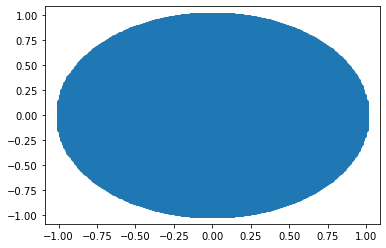

In [45]:
lspace = torch.linspace(-1, 1, steps=200, device=device, dtype=dtype)
#lspace = torch.sign(lspace) * torch.square(torch.abs(lspace))

x = torch.cartesian_prod(lspace, lspace)
x = x[torch.norm(x, dim=1) < 1]
plt.scatter(x.cpu().numpy()[:,0], x.cpu().numpy()[:,1])
plt.show()


In [62]:
samples=sampler(x).cpu()

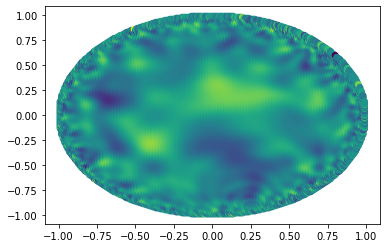

In [63]:
x_cpu = x.cpu()
plt.scatter(x_cpu[:, 0], x_cpu[:, 1], c=samples)
plt.show()

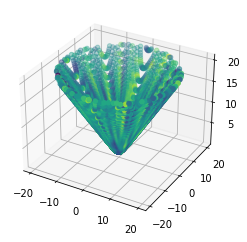

In [64]:
y = disk_to_hyperboloid(x).cpu()
indices = torch.nonzero(y[:,0] < 20)
y = torch.squeeze(y[indices])
samples = torch.squeeze(samples[indices])
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(y[:, 1], y[:, 2], y[:,0], c=samples)
plt.show()
